In [15]:
#get the imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import inspect
import random
import os
from sklearn.neighbors import KDTree
import multiprocessing as mp
import gc

In [2]:
#return keypoints from an image using SURF
def getSURFMatches(image,param):

    #use SURF to get set of keypoints and corresponding descriptors
    sift = cv2.xfeatures2d.SURF_create(param)
    kp1,des1 = sift.detectAndCompute(image,None)
    return kp1,des1

#returns set of keypoints from the set of images provided
def getRefSet(imageSet,param):
    
    pointsSet = []
    for img in imageSet:
        p,d = getSURFMatches(img,param)
        pointsSet += [d]
    return pointsSet

#returns a set of images present in a folder
def getImageSet(foldername):
    images = [cv2.imread(foldername + str(i)) for i in os.listdir(foldername)]
    return images

#computes the set of points in a query image that are less than an average distance from 
#the set of reference points
def getBestPoints(rpset,qpset):
    
    dists = []
    for q in qpset:
        sumn = np.sum(np.linalg.norm(rpset - q))
        dists += [sumn]
    
    avg = sum(dists)/len(dists)
    points = []
    for i,d in enumerate(dists):
        if d < avg:
            points += [qpset[i]]
            
    return points

#computes the set of stable points for as set of images using n-1 cross validation methods
def createTestSet(imageSet,param):
    
    #get total set of SURF points for all images
    totalPset = getRefSet(imageSet,param)
    tsetPoints = []
    for i,qpset in enumerate(totalPset):
        #reference set
        rpset = np.concatenate(totalPset[0:i] + totalPset[i+1:])
        tsetPoints += [getBestPoints(rpset,qpset)]
        
    return np.concatenate(tsetPoints)
        

In [3]:
###Testing code for reference set generation
imageSet = getImageSet("./Dataset_4NSigComp2010/TrainingSet/Reference/")
refPoints = createTestSet(imageSet,400)

In [4]:
"""
Code for getting the stable points in an image (good points)

The algorithm is a nearest neighbour classification where each 
query point is compared with k nearest stable points. The distances 
are averaged and the resuting query point is termed as a good point 
if it lies within a threshold parameter.

The parameters to the system are :
theta : threshold to determine if the point is stable based on distances
K : the number of closest points to check (1 according to the paper)
refSet : the set of reference stable points represented as a KD-Tree 
param : Input to SURF to detect keypoints (400 acccording to the paper)

The function return the average distance of the closest k points 
averaged over the entire query set of points, the percentage of good points,
the number of good points and the total number of query points.
They are collectively henceforth referred to as the 'stats' for each invocation 
with a given set of params(theta value and k value).
"""

def get_good_points(image,theta,refSet,k=1,param=400):
    
    kp,ds = getSURFMatches(image,param)
    good = 0
    kAvgDist = 0
    for q in ds:
        dist,ind = refSet.query(q.reshape(1,-1),k)
        avgDist = sum(dist)/len(dist)
        kAvgDist += avgDist
        if avgDist < theta:
            good += 1
    
    
    return kAvgDist/ds.shape[0],good/ds.shape[0],good,ds.shape[0]

In [79]:
###Testing code for getting the good points in an image based on a reference set 
kdRefSet = KDTree(refPoints,leaf_size=40)
#genuine image set 
#genImage = getImageSet("./Dataset_4NSigComp2010/TrainingSet/Genuine/")
genImage = ["./Dataset_4NSigComp2010/TrainingSet/Genuine/" + str(image) \
             for image in os.listdir("./Dataset_4NSigComp2010/TrainingSet/Genuine/")]
#forged image set
#forgImage = getImageSet("./Dataset_4NSigComp2010/TrainingSet/Simulated/")
forgImage = ["./Dataset_4NSigComp2010/TrainingSet/Simulated/" + str(image) \
             for image in os.listdir("./Dataset_4NSigComp2010/TrainingSet/Simulated/")]

#disguised images
disImage = ["./Dataset_4NSigComp2010/TrainingSet/Disguise/" + str(image) \
             for image in os.listdir("./Dataset_4NSigComp2010/TrainingSet/Disguise/")]


In [10]:
#return the stats for a set fo images based on the params, 
#the last two params can be used for multithreded invocations and are not used here
def imageStats(imageSet,theta,refSet,k=1,param=400,resp = None,resa = []):
    
    stats = []
    for i in imageSet:
        image = cv2.imread(i)
        res = get_good_points(image,theta,kdRefSet,k,param)
        stats += [[res[0][0],res[1],res[2],res[3]]]
    
    if resp is not None:
        resa[resp] = stats
        
    return stats

In [51]:
#gets the stats for a range for threshold values 
def getStatsRangeTheta(imageSet,tStart,tEnd,tStep,refSet,k,param):
    
    total = int(round((tEnd - tStart)/tStep))
    tht = [tStart + i*tStep for i in range(total)]
    Pools = mp.Pool(mp.cpu_count())
    args = [(imageSet,theta,refSet,k,param) for theta in tht]
    res = Pools.starmap(imageStats,args)
    return tht,res


In [ ]:
thts,g_res = getStatsRangeTheta(genImage,0.14,0.28,0.01,kdRefSet,1,400)

In [ ]:
thts,f_res = getStatsRangeTheta(forgImage,0.14,0.28,0.01,kdRefSet,1,400)

In [85]:
thts,d_res = getStatsRangeTheta(disImage,0.14,0.28,0.01,kdRefSet,1,400)

In [99]:
g_res = np.array(g_res)
f_res = np.array(f_res)
d_res = np.array(d_res)

In [166]:
tdata = np.concatenate((g_res,f_res,d_res),axis=1)
tlabl = np.vstack((np.ones([g_res.shape[1],1],dtype=np.int)*1, \
                   np.ones([f_res.shape[1],1],dtype=np.int)*2, \
                   np.ones([d_res.shape[1],1],dtype=np.int)*3))

tlabl2 = np.array(['genuine']*g_res.shape[1] + ['forged']*f_res.shape[1] + ['disguised']*d_res.shape[1])

In [205]:
def trainSetPredictions(images,imageType,thts,p_threshold=0.75):
    
    lbls = np.unique(imageType)
    res = []  
    for it,th in enumerate(thts):
        d = {}
        for l in lbls:
            
            temp = images[it][np.where(imageType == l)[0],1]
            true = np.sum(temp >= p_threshold)
            fals = temp.shape[0] - true
            d[l] = (true,fals)
        res += [(round(th,4),d)]
        
    return res

In [198]:
def rocPlot(results,trueLabel):
    
    x,y = [],[]
    for r in results:
        print("Threshold",r[0])
        print(r[1])
        tp,tn,fp,fn = 0,0,0,0
        for k in r[1].keys():
            if k == trueLabel:
                tp,fn = r[1][k][0],r[1][k][1]
            else:
                fp += r[1][k][0]
                tn += r[1][k][1]
        print("TRP",tp/(tp + fn),"FPR",fp/(tn + fp))
        print("------------------------------------")
        x += [tp/(tp + fn)]
        y += [fp/(tn + fp)]
        
    plt.figure(figsize=(10,8))
    plt.plot(y,x)
    plt.ylabel("True Positive Rate")
    plt.xlabel('False Positive Rate')
    plt.title("ROC curve for threshold range " + str(results[0][0]) + " - " + str(results[-1][0]) + " inclusive")
    plt.show()

In [199]:
res = trainSetPredictions(tdata,tlabl2,thts)

Threshold 0.14
{'disguised': (0, 20), 'forged': (0, 104), 'genuine': (0, 76)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.15
{'disguised': (0, 20), 'forged': (0, 104), 'genuine': (0, 76)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.16
{'disguised': (0, 20), 'forged': (0, 104), 'genuine': (0, 76)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.17
{'disguised': (0, 20), 'forged': (0, 104), 'genuine': (0, 76)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.18
{'disguised': (0, 20), 'forged': (0, 104), 'genuine': (0, 76)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.19
{'disguised': (0, 20), 'forged': (0, 104), 'genuine': (0, 76)}
TRP 0.0 FPR 0.0
------------------------------------
Threshold 0.2
{'disguised': (0, 20), 'forged': (1, 103), 'genuine': (5, 71)}
TRP 0.06578947368421052 FPR 0.008064516129032258
------------------------------------
Threshold 0.21
{'disguised': (4, 16), 'forged': (12

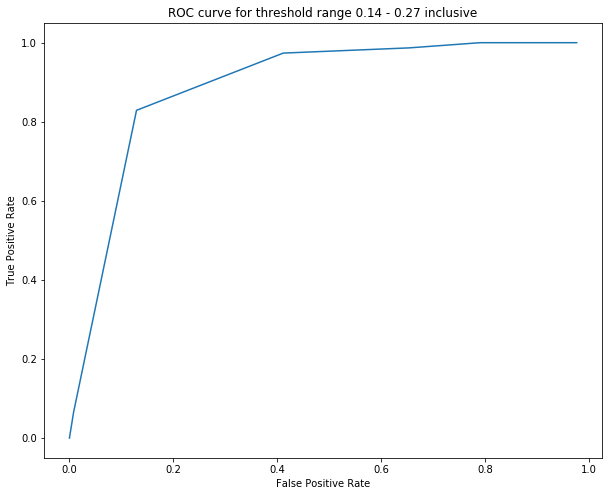

In [200]:
rocPlot(res,'genuine')

In [201]:
thts2,g_res2 = getStatsRangeTheta(genImage,0.2,0.23,0.002,kdRefSet,1,400)
thts2,f_res2 = getStatsRangeTheta(forgImage,0.2,0.23,0.002,kdRefSet,1,400)
thts2,d_res2 = getStatsRangeTheta(disImage,0.2,0.23,0.002,kdRefSet,1,400)

In [202]:
g_res2 = np.array(g_res2)
f_res2 = np.array(f_res2)
d_res2 = np.array(d_res2)
np.save("g_0.2_0.23_0.002_k1",g_res2)
np.save("f_0.2_0.23_0.002_k1",f_res2)
np.save("d_0.2_0.23_0.002_k1",d_res2)

In [203]:
tdata2 = np.concatenate((g_res2,f_res2,d_res2),axis=1)
tlabl2_ = np.array(['genuine']*g_res2.shape[1] + ['forged']*f_res2.shape[1] + ['disguised']*d_res2.shape[1])

Threshold 0.2
{'disguised': (0, 20), 'forged': (1, 103), 'genuine': (5, 71)}
TRP 0.06578947368421052 FPR 0.008064516129032258
------------------------------------
Threshold 0.202
{'disguised': (0, 20), 'forged': (2, 102), 'genuine': (11, 65)}
TRP 0.14473684210526316 FPR 0.016129032258064516
------------------------------------
Threshold 0.204
{'disguised': (1, 19), 'forged': (6, 98), 'genuine': (29, 47)}
TRP 0.3815789473684211 FPR 0.056451612903225805
------------------------------------
Threshold 0.206
{'disguised': (1, 19), 'forged': (8, 96), 'genuine': (40, 36)}
TRP 0.5263157894736842 FPR 0.07258064516129033
------------------------------------
Threshold 0.208
{'disguised': (3, 17), 'forged': (11, 93), 'genuine': (48, 28)}
TRP 0.631578947368421 FPR 0.11290322580645161
------------------------------------
Threshold 0.21
{'disguised': (4, 16), 'forged': (12, 92), 'genuine': (63, 13)}
TRP 0.8289473684210527 FPR 0.12903225806451613
------------------------------------
Threshold 0.212
{'

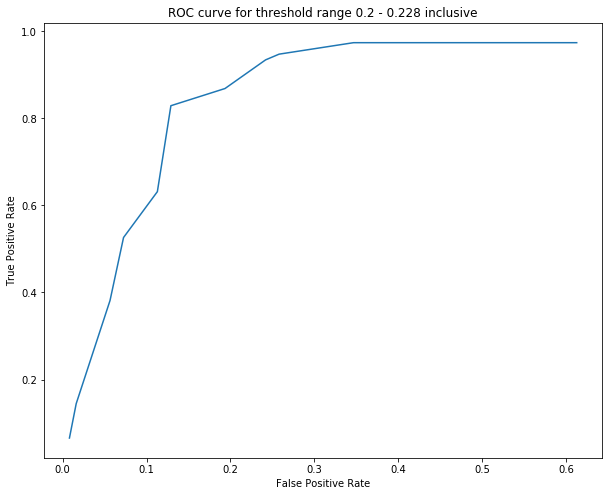

In [207]:
res = trainSetPredictions(tdata2,tlabl2_,thts2)
rocPlot(res,'genuine')

In [33]:
Pools = mp.Pool(mp.cpu_count())
#res = mp.Array('d',[None,None])
#args = [[genImage,0.14,kdRefSet,1,400,0,res],[genImage,0.16,kdRefSet,1,400,1,res]]
args = [(2,3),(5,4),(3,3),(3,2),(2,3),(5,4),(3,3),(3,2),(2,3),(5,4),(3,3),(3,2),(2,3),(5,4),(3,3),(3,222)]
Pools.starmap(abc,args)`

[5, 9, 6, 5, 5, 9, 6, 5, 5, 9, 6, 5, 5, 9, 6, 225]

In [94]:
np.save("forg_0.14_0.28_k1",f_res)

In [95]:
np.save("des_0.14.0.28_k1",d_res)

In [118]:
def get_distance(image,stable_points,theta):
    img = cv2.imread(image)
    kp,ds = getSURFMatches(img,400)
    good = 0
    bad = 0
    for i in r.2ange(ds.shape[0]):
        sumn = (np.sum((stable_points - ds[i])**2,axis = 1))**(0.5)
#         print (min(sumn),max(sumn))
        if (min(sumn) <= theta):
            good += 1
        else:
            bad += 1
    
    return good,bad

In [133]:
def get_theta(stable_keypoint):
    genuine_pics = glob.glob('../Dataset_4NSigComp2010/TrainingSet/Genuine/*.png')
    forged_pic = glob.glob('../Dataset_4NSigComp2010/TrainingSet/Simulated/*.png')
    disguised_pic = glob.glob('../Dataset_4NSigComp2010/TrainingSet/Disguise/*.png')
    theta = 0.17
    tp = 0
    fn = 0
    fp = 0
    tn = 0
    print (len(genuine_pics),len(forged_pic),len(disguised_pic))
    for i in range(len(genuine_pics)):
        good_points,bad_points = get_distance(genuine_pics[i],stable_keypoint,theta)
        print (i,"Good Points",good_points,"Bad Points",bad_points,good_points/(good_points + bad_points))
#         if i == 5:
#             break
        
    print ("\n")
    for i in range(len(forged_pic)):
        good_points,bad_points = get_distance(forged_pic[i],stable_keypoint,theta)
        print (i,"Good Points",good_points,"Bad Points",bad_points,good_points/(good_points + bad_points))
#         if i == 5:
#             break
    
    print ("\n")
    for i in range(len(disguised_pic)):
        good_points,bad_points = get_distance(disguised_pic[i],stable_keypoint,theta)
        print (i,"Good Points",good_points,"Bad Points",bad_points,good_points/(good_points + bad_points))
#         if i == 5:
#             break
    
#     FPR = fp/(fp + tn)
#     FNR = fn/(tp + fn)
#     print (tp,tn,fp,fn)
    

In [131]:
images = getImageSet("/home/shad3/Downloads/Computer_vision/Project/Dataset_4NSigComp2010/TrainingSet/Reference/")

In [84]:
test_set = createTestSet(images,400)

In [134]:
get_theta(test_set)

76 104 20
0 Good Points 1205 Bad Points 714 0.627931214174049
1 Good Points 1379 Bad Points 1033 0.5717247097844113
2 Good Points 1500 Bad Points 1068 0.5841121495327103
3 Good Points 1444 Bad Points 1105 0.5664966653589643
4 Good Points 1454 Bad Points 1150 0.5583717357910907
5 Good Points 1394 Bad Points 983 0.5864535128313
6 Good Points 1565 Bad Points 1032 0.6026184058529072
7 Good Points 1321 Bad Points 1124 0.5402862985685072
8 Good Points 1671 Bad Points 1181 0.5859046283309958
9 Good Points 1681 Bad Points 1154 0.5929453262786596
10 Good Points 1394 Bad Points 1256 0.5260377358490566
11 Good Points 1302 Bad Points 1087 0.5449979070740896
12 Good Points 1642 Bad Points 1154 0.5872675250357654
13 Good Points 1900 Bad Points 1058 0.6423258958755916
14 Good Points 1502 Bad Points 1150 0.5663650075414781
15 Good Points 988 Bad Points 1022 0.49154228855721394
16 Good Points 1582 Bad Points 804 0.6630343671416596
17 Good Points 1496 Bad Points 1147 0.5660234581914491
18 Good Points 12

76 Good Points 1185 Bad Points 1370 0.4637964774951076
77 Good Points 783 Bad Points 816 0.4896810506566604
78 Good Points 990 Bad Points 864 0.5339805825242718
79 Good Points 1248 Bad Points 775 0.6169055857637172
80 Good Points 586 Bad Points 825 0.4153082919914954
81 Good Points 1374 Bad Points 1465 0.4839732300105671
82 Good Points 990 Bad Points 1117 0.4698623635500712
83 Good Points 1076 Bad Points 1201 0.4725516029863856
84 Good Points 1034 Bad Points 1195 0.4638851502916106
85 Good Points 415 Bad Points 721 0.3653169014084507
86 Good Points 1666 Bad Points 1349 0.5525704809286899
87 Good Points 787 Bad Points 1109 0.415084388185654
88 Good Points 1446 Bad Points 1293 0.5279299014238773
89 Good Points 1275 Bad Points 1270 0.5009823182711198
90 Good Points 432 Bad Points 683 0.3874439461883408
91 Good Points 1794 Bad Points 996 0.6430107526881721
92 Good Points 1028 Bad Points 745 0.5798082346305696
93 Good Points 718 Bad Points 731 0.49551414768806074
94 Good Points 851 Bad Poin

In [ ]:
asdf